In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
import torch.nn.init as ini
import h5py
import random

#in order to access the parameters, I have to separate the seg layers from the Unet module
class Unetpure(nn.Module):
    def __init__(self):
        super(Unetpure, self).__init__()
        self.first_layer_down_conv1 = nn.Conv3d(2, 8, 3, padding = 1)
        self.first_layer_down_bn1 = nn.BatchNorm3d(8)
        self.first_layer_down_pre1 = nn.PReLU()
        self.second_layer_down_conv1 = nn.Conv3d(8, 16, 3, padding = 1, stride = 2)
        self.second_layer_down_bn1 = nn.BatchNorm3d(16)
        self.second_layer_down_pre1 = nn.PReLU()
        self.second_layer_down_conv2 = nn.Conv3d(16, 16, 3, padding = 1)
        self.second_layer_down_bn2 = nn.BatchNorm3d(16)
        self.second_layer_down_pre2 = nn.PReLU()
        self.third_layer_down_conv1 = nn.Conv3d(16, 32, 3, padding = 1, stride = 2)
        self.third_layer_down_bn1 = nn.BatchNorm3d(32)
        self.third_layer_down_pre1 = nn.PReLU()
        self.third_layer_down_conv2 = nn.Conv3d(32, 32, 3, padding = 1)
        self.third_layer_down_bn2 = nn.BatchNorm3d(32)
        self.third_layer_down_pre2 = nn.PReLU()
        self.fourth_layer_down_conv1 = nn.Conv3d(32, 64, 3, padding = 1, stride = 2)
        self.fourth_layer_down_bn1 = nn.BatchNorm3d(64)
        self.fourth_layer_down_pre1 = nn.PReLU()
        self.fourth_layer_down_conv2 = nn.Conv3d(64, 64, 3, padding = 1)
        self.fourth_layer_up_conv1 = nn.Conv3d(64, 64, 1)
        self.fourth_layer_up_bn1 = nn.BatchNorm3d(64)
        self.fourth_layer_up_pre1 = nn.PReLU()
        self.fourth_layer_up_deconv = nn.ConvTranspose3d(64, 32, 3, padding = 1, output_padding = 1, stride = 2)
        self.fourth_layer_up_bn2 = nn.BatchNorm3d(32)
        self.fourth_layer_up_pre2 = nn.PReLU()
        self.third_layer_up_conv1 = nn.Conv3d(64, 64, 3, padding = 1)
        self.third_layer_up_bn1 = nn.BatchNorm3d(64)
        self.third_layer_up_pre1 = nn.PReLU()
        self.third_layer_up_conv2 = nn.Conv3d(64, 32, 1)
        self.third_layer_up_bn2 = nn.BatchNorm3d(32)
        self.third_layer_up_pre2 = nn.PReLU()
        self.third_layer_up_deconv = nn.ConvTranspose3d(32, 16, 3, padding = 1, output_padding = 1, stride = 2)
        self.third_layer_up_bn3 = nn.BatchNorm3d(16)
        self.third_layer_up_pre3 = nn.PReLU()
        self.second_layer_up_conv1 = nn.Conv3d(32, 32, 3, padding = 1)
        self.second_layer_up_bn1 = nn.BatchNorm3d(32)
        self.second_layer_up_pre1 = nn.PReLU()
        self.second_layer_up_conv2 = nn.Conv3d(32, 16, 1)
        self.second_layer_up_bn2 = nn.BatchNorm3d(16)
        self.second_layer_up_pre2 = nn.PReLU()
        self.second_layer_up_deconv = nn.ConvTranspose3d(16, 8, 3, padding = 1, output_padding = 1, stride = 2)
        self.second_layer_up_bn3 = nn.BatchNorm3d(8)
        self.second_layer_up_pre3 = nn.PReLU()
        self.first_layer_up_conv1 = nn.Conv3d(16, 16, 3, padding = 1)
        self.first_layer_up_bn1 = nn.BatchNorm3d(16)
        self.first_layer_up_pre1 = nn.PReLU()
        
#         self.third_seg = nn.Conv3d(64, 3, 1)
#         self.second_seg = nn.Conv3d(32, 3, 1)
#         self.first_seg = nn.Conv3d(16, 3, 1)
        self.upsample_layer = nn.Upsample(scale_factor = 2, mode = 'trilinear')

    def forward(self, x):
        x = self.first_layer_down_conv1(x)
        x = self.first_layer_down_bn1(x)
        x = self.first_layer_down_pre1(x)
        first_layer_feature = x
        
        x = self.second_layer_down_conv1(x)
        temp = x
        x = self.second_layer_down_bn1(x)
        x = self.second_layer_down_pre1(x)
        x = self.second_layer_down_conv2(x)
        x = torch.add(x, temp)
        x = self.second_layer_down_bn2(x)
        x = self.second_layer_down_pre2(x)
        second_layer_feature = x
        
        x = self.third_layer_down_conv1(x)
        temp = x
        x = self.third_layer_down_bn1(x)
        x = self.third_layer_down_pre1(x)
        x = self.third_layer_down_conv2(x)
        x = torch.add(x, temp)
        x = self.third_layer_down_bn2(x)
        x = self.third_layer_down_pre2(x)
        third_layer_feature = x
        
        x = self.fourth_layer_down_conv1(x)
        temp = x
        x = self.fourth_layer_down_bn1(x)
        x = self.fourth_layer_down_pre1(x)
        x = self.fourth_layer_down_conv2(x)
        x = torch.add(x, temp)
        
        x = self.fourth_layer_up_conv1(x)
        x = self.fourth_layer_up_bn1(x)
        x = self.fourth_layer_up_pre1(x)
        x = self.fourth_layer_up_deconv(x)
        x = self.fourth_layer_up_bn2(x)
        x = self.fourth_layer_up_pre2(x)
        
        x = torch.cat((x, third_layer_feature), 1)
        x = self.third_layer_up_conv1(x)
        x = self.third_layer_up_bn1(x)
        x = self.third_layer_up_pre1(x)
        
        #third_seg_map = self.third_seg(x)
        third_seg_feature = x
        x = self.third_layer_up_conv2(x)
        x = self.third_layer_up_bn2(x)
        x = self.third_layer_up_pre2(x)
        x = self.third_layer_up_deconv(x)
        x = self.third_layer_up_bn3(x)
        x = self.third_layer_up_pre3(x)
        
        x = torch.cat((x, second_layer_feature), 1)
        x = self.second_layer_up_conv1(x)
        x = self.second_layer_up_bn1(x)
        x = self.second_layer_up_pre1(x)
        
        #second_seg_map = self.second_seg(x)
        second_seg_feature = x
        x = self.second_layer_up_conv2(x)
        x = self.second_layer_up_bn2(x)
        x = self.second_layer_up_pre2(x)
        x = self.second_layer_up_deconv(x)
        x = self.second_layer_up_bn3(x)
        x = self.second_layer_up_pre3(x)
        
        x = torch.cat((x, first_layer_feature), 1)
        x = self.first_layer_up_conv1(x)
        x = self.first_layer_up_bn1(x)
        x = self.first_layer_up_pre1(x)
        
        #first_seg_map = self.first_seg(x)
        first_seg_feature = x
#         third_seg_map = self.upsample_layer(third_seg_map)
#         second_seg_map = torch.add(third_seg_map, second_seg_map)
#         second_seg_map = self.upsample_layer(second_seg_map)
#         x = torch.add(first_seg_map, second_seg_map)
        return third_seg_feature, second_seg_feature, first_seg_feature

netpure=Unetpure()

In [2]:
class Unetseg(nn.Module):
    def __init__(self, net1):
        super(Unetseg, self).__init__()
        self.Unetpure=net1
        self.third_seg = nn.Conv3d(64, 3, 1)
        self.second_seg = nn.Conv3d(32, 3, 1)
        self.first_seg = nn.Conv3d(16, 3, 1)
        self.upsample_layer = nn.Upsample(scale_factor = 2, mode = 'trilinear')
    def forward(self, x):
        third_seg_feature, second_seg_feature, first_seg_feature=self.Unetpure(x)
        third_seg_map = self.third_seg(third_seg_feature)
        second_seg_map = self.second_seg(second_seg_feature)
        first_seg_map = self.first_seg(first_seg_feature)
        third_seg_map = self.upsample_layer(third_seg_map)
        second_seg_map = torch.add(third_seg_map, second_seg_map)
        second_seg_map = self.upsample_layer(second_seg_map)
        x = torch.add(first_seg_map, second_seg_map)
        return x

net=Unetseg(netpure)
net.cuda(2)

Unetseg (
  (Unetpure): Unetpure (
    (first_layer_down_conv1): Conv3d(2, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (first_layer_down_bn1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True)
    (first_layer_down_pre1): PReLU (1)
    (second_layer_down_conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (second_layer_down_bn1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True)
    (second_layer_down_pre1): PReLU (1)
    (second_layer_down_conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (second_layer_down_bn2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True)
    (second_layer_down_pre2): PReLU (1)
    (third_layer_down_conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (third_layer_down_bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True)
    (third_layer_down_pre1): PReLU (1)
    (third_layer_down_conv2): Conv3d(32, 32, kernel_size=(3

In [4]:
#parameter initialization
for param in net.parameters():
    try:
        nout = param.size()[0]
        nin = param.size()[1]
        ini.normal(param.data, mean = 0, std = 0.01)
        param = param / ((2/(nin+nout))**0.5)
    except:
        pass

#data setup
f = h5py.File('/home/yiqin/train/Unet-training.h5')
SAMPLE = [ "LG/0001", "LG/0002", "LG/0004", "LG/0006", "LG/0008", "LG/0011",
          "LG/0012", "LG/0013", "LG/0014", "LG/0015", "HG/0001", "HG/0002",
          "HG/0003", "HG/0004", "HG/0005", "HG/0006", "HG/0007", "HG/0008",
          "HG/0009", "HG/0010", "HG/0011", "HG/0012", "HG/0013", "HG/0014",
          "HG/0015", "HG/0022", "HG/0024", "HG/0025", "HG/0026"]

def create_train_batch(img = 0):
    case = SAMPLE[img]
    key0 = case[:2]
    key1 = case[3:]
    _, X, Y, Z = f[key0][key1].shape
    train_batch = [];
    train_label = [];
    x = random.randint(64, X-64)
    y = random.randint(64, Y-64)
    z = random.randint(48, Z-48)
    train_batch.append(f[key0][key1][0:2,x-64:x+64,y-64:y+64,z-48:z+48])
    
    #deal with 2cp, reduce 5 label to 3 label
    temporary_label=f[key0][key1][4,x-64:x+64,y-64:y+64,z-48:z+48]
    temporary_label[temporary_label==3]=1
    temporary_label[temporary_label==4]=1
    train_label.append(temporary_label)
    
    train_batch = np.array(train_batch)
    train_label = np.array(train_label)
    train_batch = torch.from_numpy(train_batch)
    train_label = torch.from_numpy(train_label)
    train_label = torch.Tensor.long(train_label)
    return train_batch, train_label

def create_val():
    case = "LG/0008"
    key0 = case[:2]
    key1 = case[3:]
    _, X, Y, Z = f[key0][key1].shape
    val_batch = [];
    val_label = [];
    x = X//2
    y = Y//2
    z = Z//2
    val_batch.append(f[key0][key1][0:2,x-64:x+64,y-64:y+64,z-48:z+48])
    
    #deal with 2cp, reduce 5 label to 3 label
    temporary_label=f[key0][key1][4,x-64:x+64,y-64:y+64,z-48:z+48]
    temporary_label[temporary_label==3]=1
    temporary_label[temporary_label==4]=1
    val_label.append(temporary_label)
    val_batch = np.array(val_batch)
    val_label = np.array(val_label)
    val_batch = torch.from_numpy(val_batch)
    val_label = torch.from_numpy(val_label)
    val_label = torch.Tensor.long(val_label)
    return val_batch, val_label

In [4]:
# #check that the code so far works
# import matplotlib.pyplot as plt
# val_x, val_y = create_val()
# val_x = Variable(val_x).cuda(2)
# y_pred = net.forward(val_x)
# y_pred = y_pred.view(3,-1)
# _, y_pred = torch.max(y_pred, 0)
# y_pred = y_pred.view(128,128,96)
# array_image = y_pred.data.cpu().numpy()

# plt.imshow(array_image[:,:,60], cmap = 'gray')
# plt.show()
# val_yn = val_y.numpy()
# print(val_yn.shape)

# #remove these two lines if run on server, for server can not "show"
# plt.imshow(val_yn[0,:,:,60], cmap = 'gray')
# plt.show()

In [5]:
#training process
val_x, val_y = create_val()
val_x = Variable(val_x).cuda(2)

#setup the weight for cross-entropy loss
w = torch.Tensor([0.14/3, 1.169/3, 0.676/3])
w = w.cuda(2)

num_epoch = 200
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr = 5e-4, weight_decay = 5e-10)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.99)
prev_time = time.clock()

for i in range(num_epoch):
    random.shuffle(SAMPLE)
    for j in range(len(SAMPLE)):
        train_batch, val_batch = create_train_batch(j)
        train_batch = Variable(train_batch).cuda(2)
        val_batch = Variable(val_batch).cuda(2)
        out = net.forward(train_batch)
        out = torch.transpose(out, 0, 1)
        out.contiguous()
        out = out.view(3, -1)
        out = torch.transpose(out, 0, 1)
        out.contiguous()
        val_batch = val_batch.view(-1)
        criterion = nn.CrossEntropyLoss(weight = w)
        loss = criterion(out, val_batch)
        optimizer.zero_grad()
        loss.backward()
        print(loss)
        
        optimizer.step()
        y_pred = net.forward(val_x)
        y_pred = y_pred.view(3, -1)
        y_pred = torch.transpose(y_pred, 0, 1)
        out.contiguous()
        _, y_pred = torch.max(y_pred.data, 1)
        correct = (y_pred.cpu() == val_y).sum()
        print('Validation accuracy:', float(correct) / 128 / 128 / 96)
        print('time used:%.3f'% (time.clock() - prev_time))
    #scheduler.step()

torch.save(net.Unetpure.state_dict(), "/home/yiqin/TumorSeg/unified_system/unet_module/u_net_pure_2cp014011690676.txt")
torch.save(net.state_dict(), "/home/yiqin/TumorSeg/unified_system/unet_module/u_net_2cp014011690676.txt" )
print ("successfully saved!")

Variable containing:
 1.1775
[torch.cuda.FloatTensor of size 1 (GPU 2)]

Validation accuracy: 0.027313868204752605
time used:4.530


/home/yiqin/anaconda3/lib/python3.6/site-packages/torch/tensor.py:345: UserWarning: self and other not broadcastable, but have the same number of elements.  Falling back to deprecated pointwise behavior.
  return self.eq(other)


Variable containing:
 1.2584
[torch.cuda.FloatTensor of size 1 (GPU 2)]

Validation accuracy: 0.027313868204752605
time used:6.353
Variable containing:
 1.2299
[torch.cuda.FloatTensor of size 1 (GPU 2)]

Validation accuracy: 0.027338027954101562
time used:8.169
Variable containing:
 1.1807
[torch.cuda.FloatTensor of size 1 (GPU 2)]

Validation accuracy: 0.034877777099609375
time used:9.994
Variable containing:
 1.2527
[torch.cuda.FloatTensor of size 1 (GPU 2)]

Validation accuracy: 0.03450775146484375
time used:11.815
Variable containing:
 1.1593
[torch.cuda.FloatTensor of size 1 (GPU 2)]

Validation accuracy: 0.034412384033203125
time used:13.637
Variable containing:
 1.1373
[torch.cuda.FloatTensor of size 1 (GPU 2)]

Validation accuracy: 0.03500684102376302
time used:15.463
Variable containing:
 1.1296
[torch.cuda.FloatTensor of size 1 (GPU 2)]

Validation accuracy: 0.03762944539388021
time used:17.285
Variable containing:
 1.2074
[torch.cuda.FloatTensor of size 1 (GPU 2)]

Validatio

KeyboardInterrupt: 

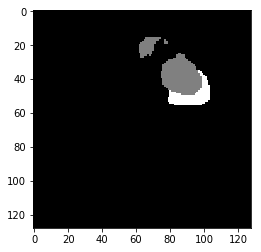

(1, 128, 128, 96)


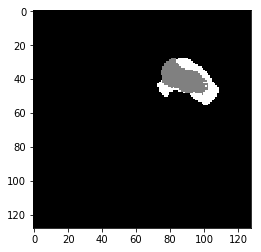

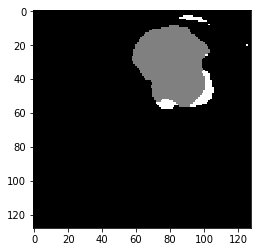

(1, 128, 128, 96)


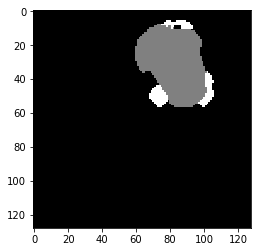

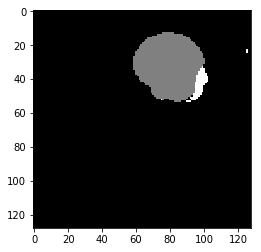

(1, 128, 128, 96)


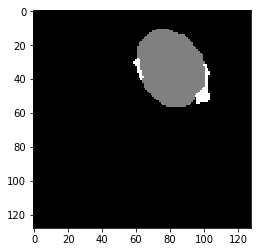

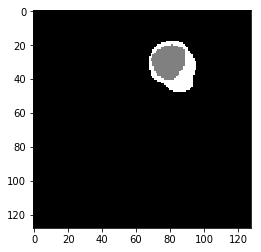

(1, 128, 128, 96)


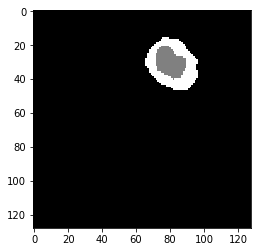

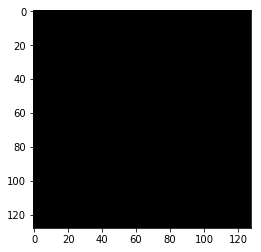

(1, 128, 128, 96)


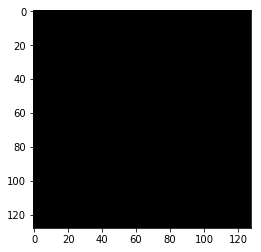

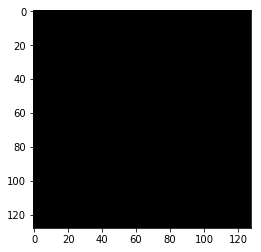

(1, 128, 128, 96)


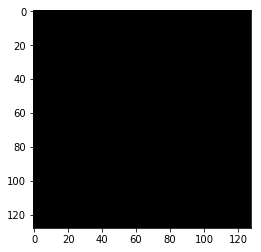

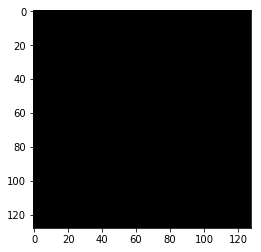

(1, 128, 128, 96)


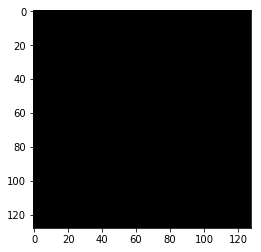

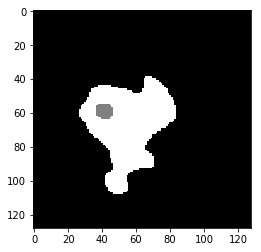

(1, 128, 128, 96)


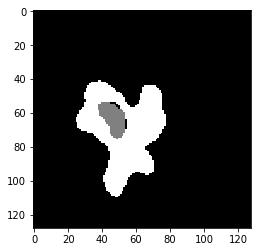

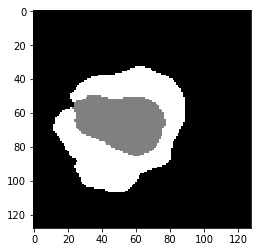

(1, 128, 128, 96)


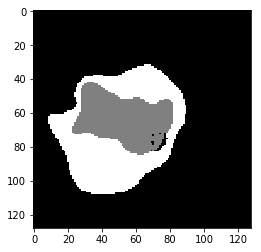

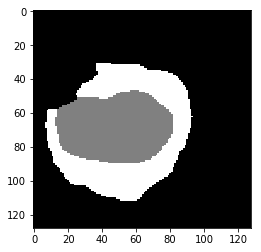

(1, 128, 128, 96)


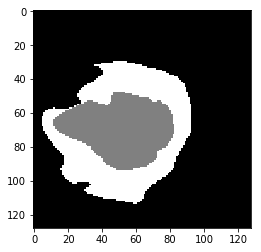

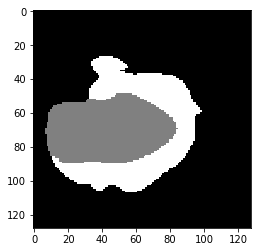

(1, 128, 128, 96)


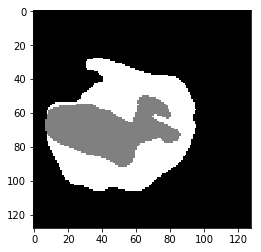

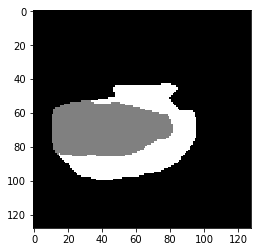

(1, 128, 128, 96)


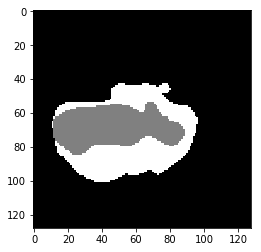

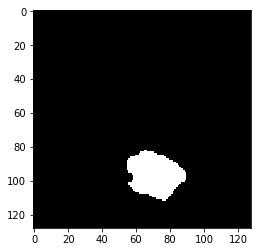

(1, 128, 128, 96)


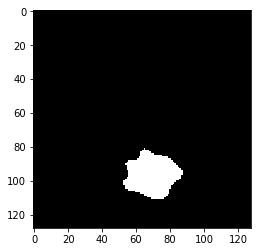

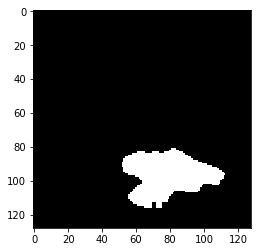

(1, 128, 128, 96)


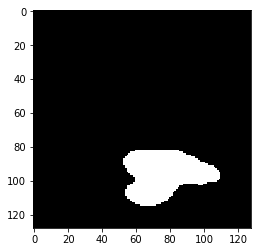

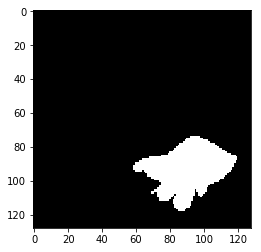

(1, 128, 128, 96)


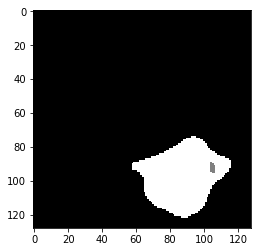

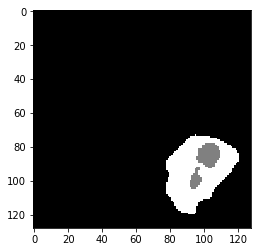

(1, 128, 128, 96)


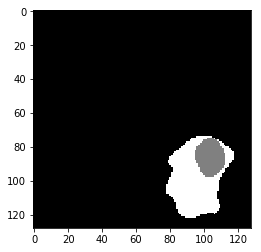

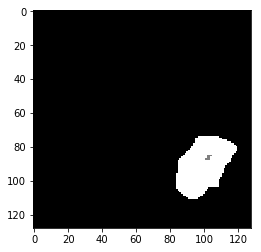

(1, 128, 128, 96)


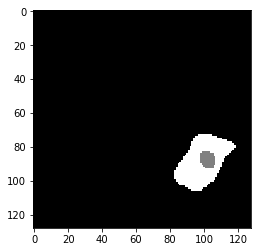

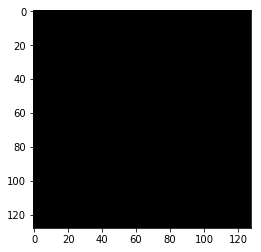

(1, 128, 128, 96)


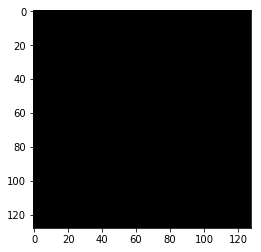

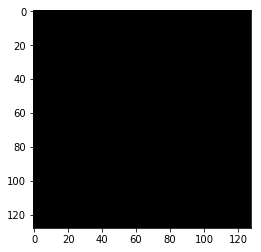

(1, 128, 128, 96)


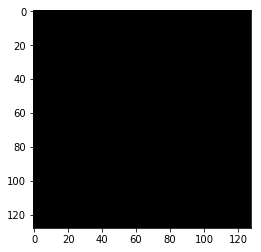

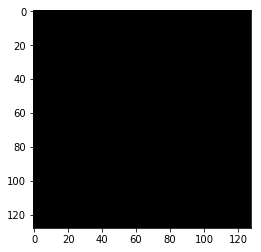

(1, 128, 128, 96)


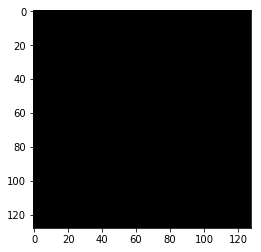

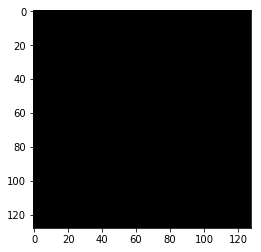

(1, 128, 128, 96)


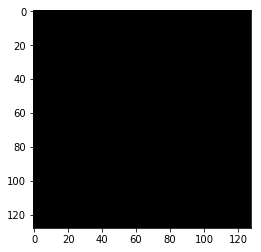

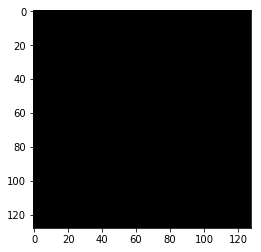

(1, 128, 128, 96)


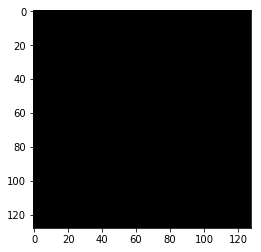

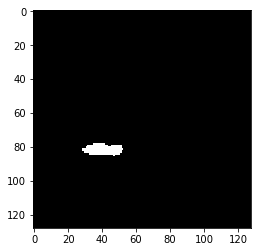

(1, 128, 128, 96)


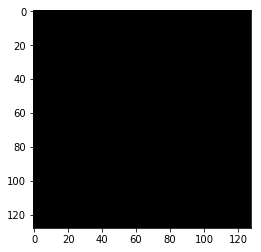

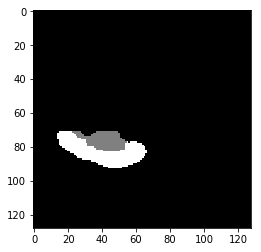

(1, 128, 128, 96)


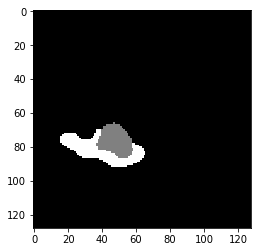

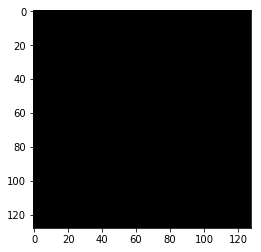

(1, 128, 128, 96)


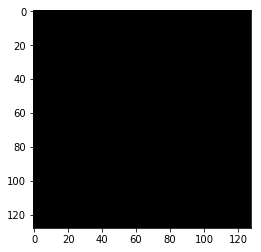

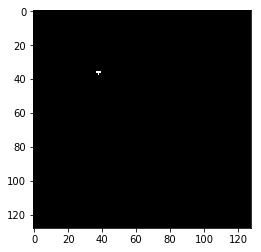

(1, 128, 128, 96)


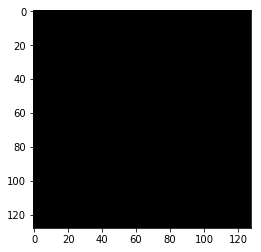

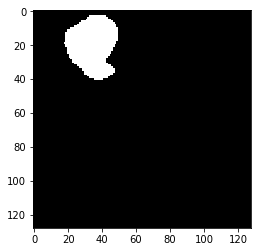

(1, 128, 128, 96)


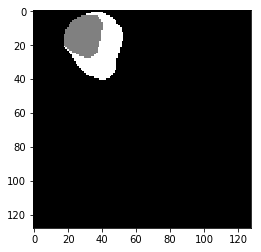

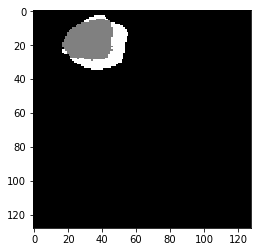

(1, 128, 128, 96)


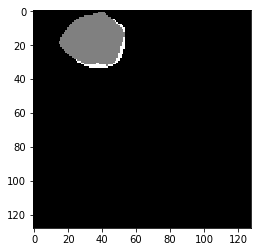

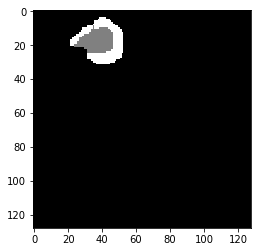

(1, 128, 128, 96)


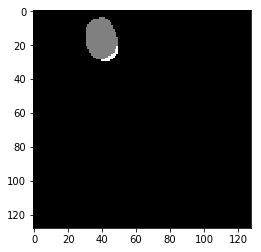

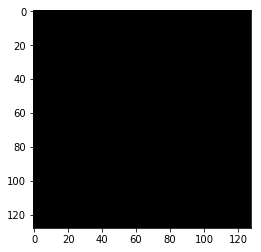

(1, 128, 128, 96)


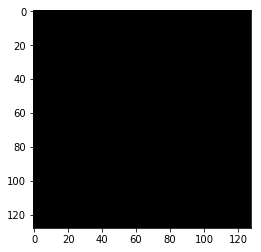

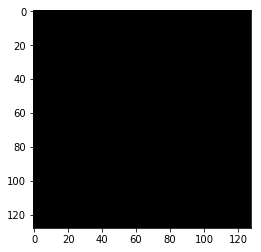

(1, 128, 128, 96)


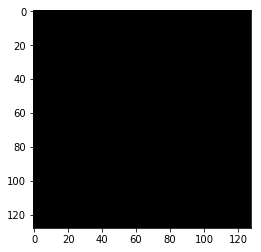

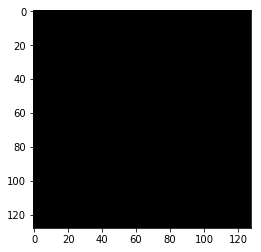

(1, 128, 128, 96)


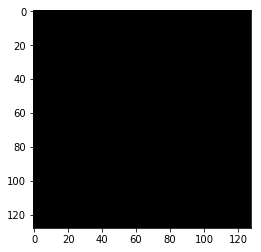

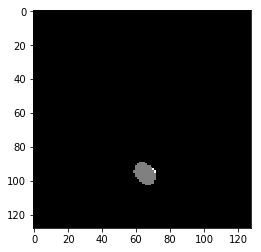

(1, 128, 128, 96)


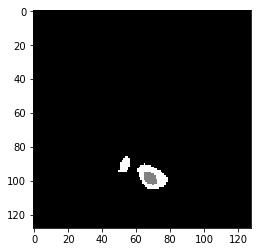

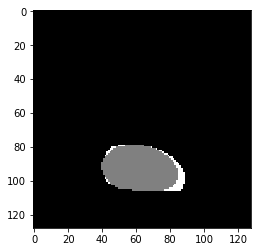

(1, 128, 128, 96)


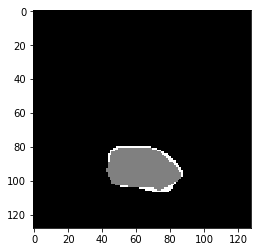

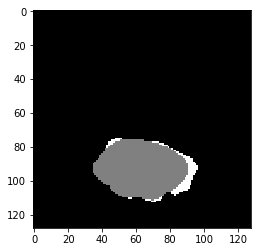

(1, 128, 128, 96)


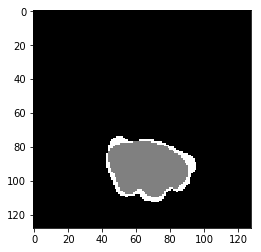

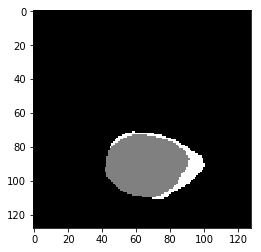

(1, 128, 128, 96)


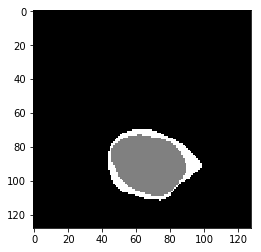

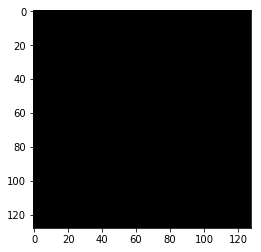

(1, 128, 128, 96)


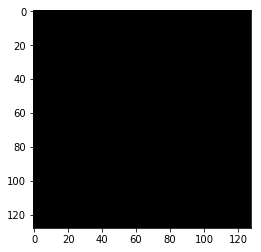

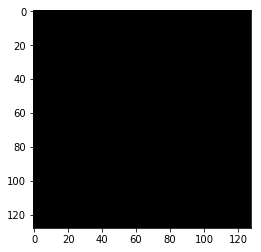

(1, 128, 128, 96)


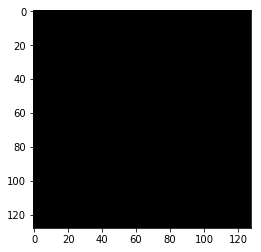

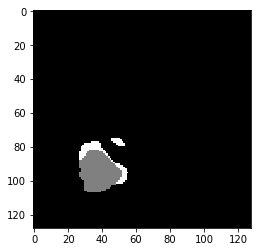

(1, 128, 128, 96)


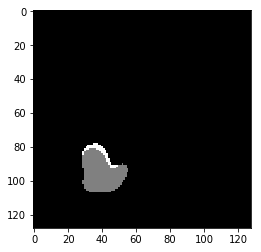

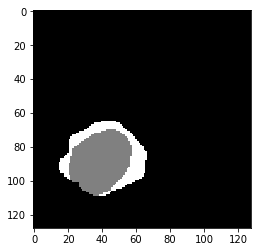

(1, 128, 128, 96)


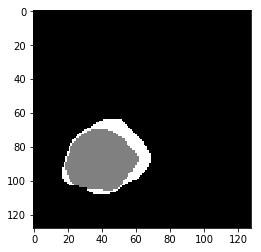

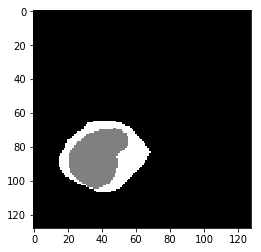

(1, 128, 128, 96)


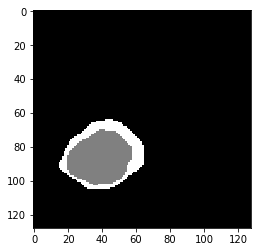

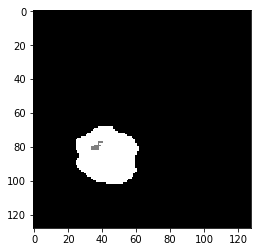

(1, 128, 128, 96)


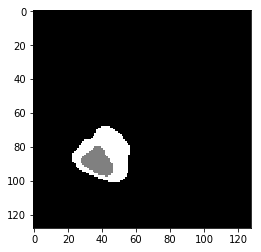

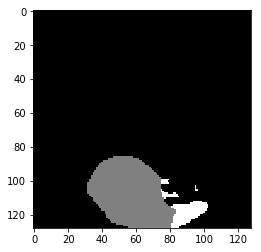

(1, 128, 128, 96)


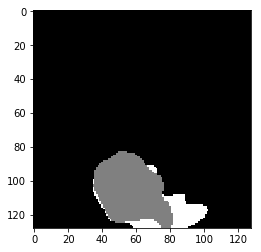

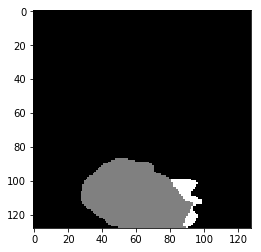

(1, 128, 128, 96)


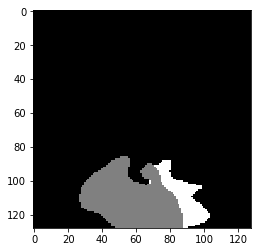

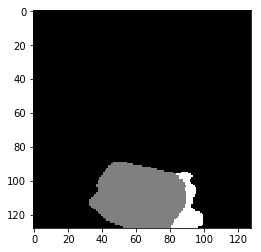

(1, 128, 128, 96)


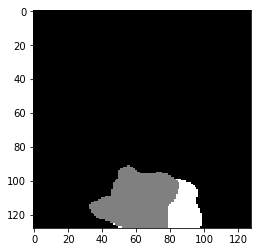

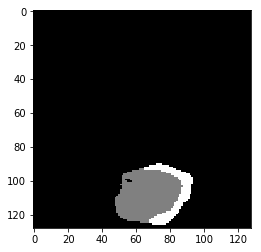

(1, 128, 128, 96)


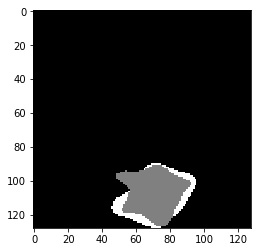

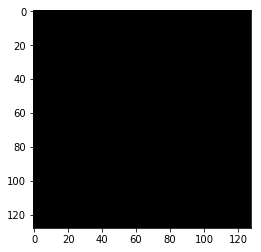

(1, 128, 128, 96)


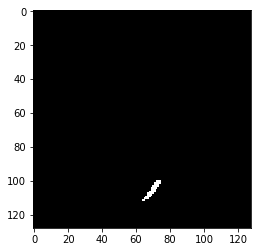

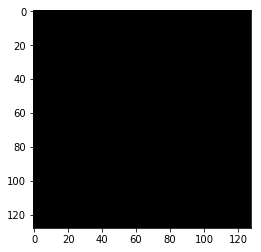

(1, 128, 128, 96)


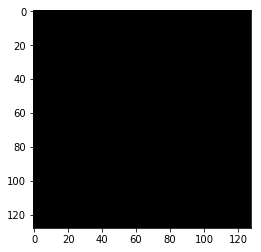

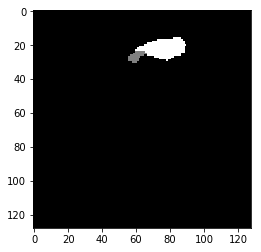

(1, 128, 128, 96)


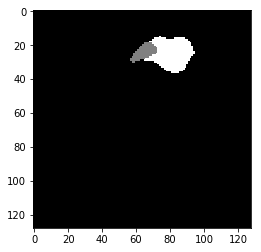

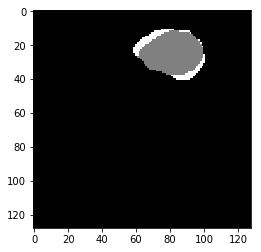

(1, 128, 128, 96)


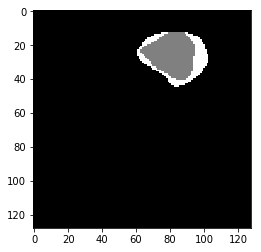

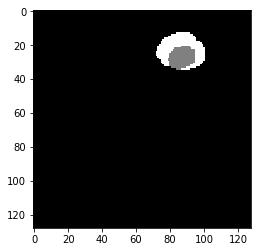

(1, 128, 128, 96)


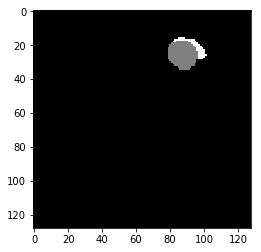

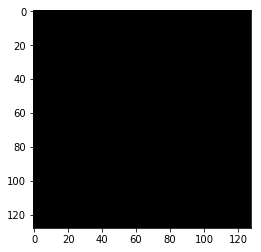

(1, 128, 128, 96)


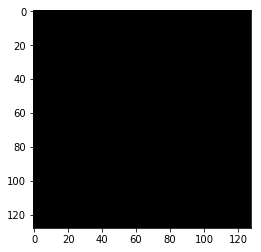

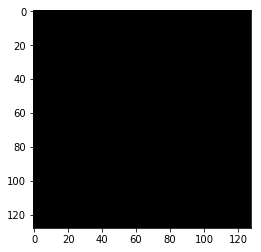

(1, 128, 128, 96)


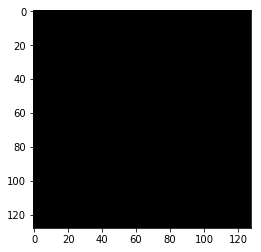

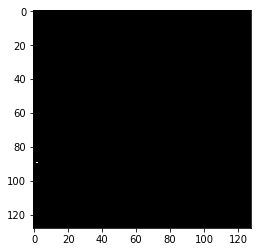

(1, 128, 128, 96)


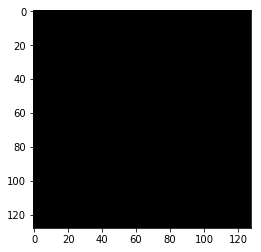

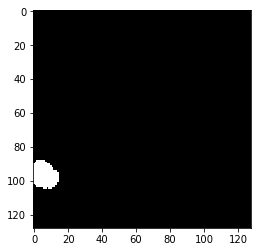

(1, 128, 128, 96)


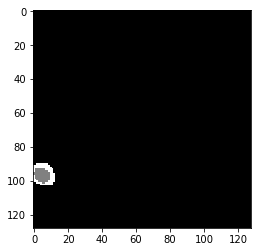

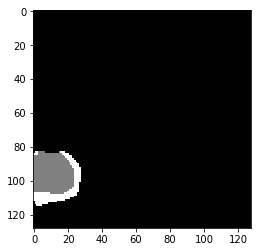

(1, 128, 128, 96)


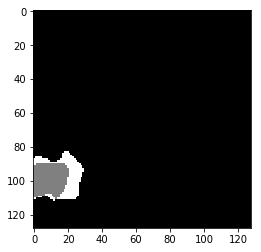

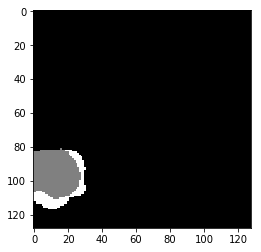

(1, 128, 128, 96)


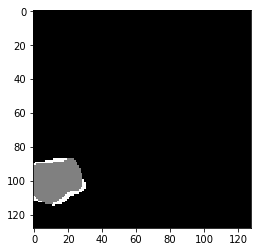

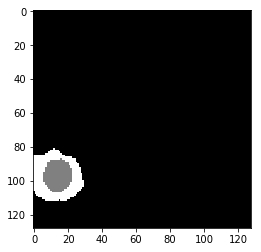

(1, 128, 128, 96)


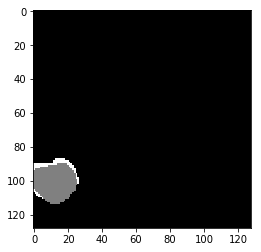

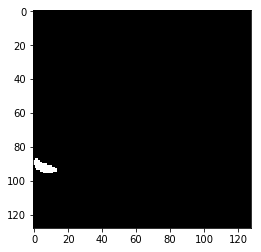

(1, 128, 128, 96)


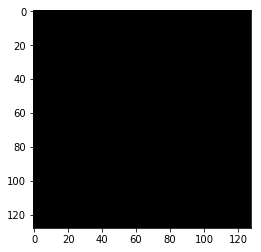

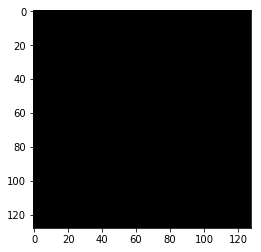

(1, 128, 128, 96)


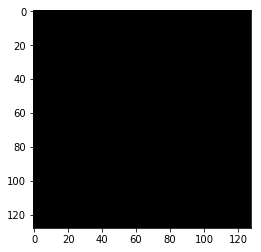

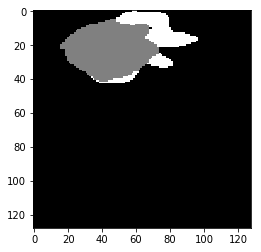

(1, 128, 128, 96)


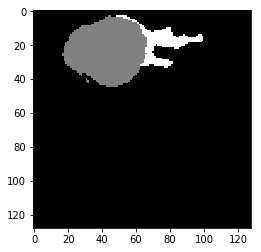

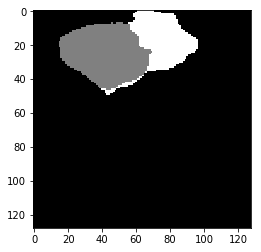

(1, 128, 128, 96)


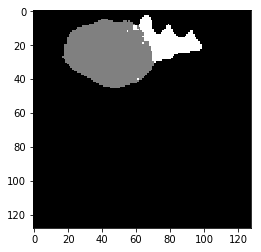

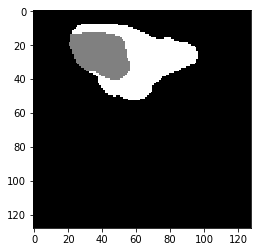

(1, 128, 128, 96)


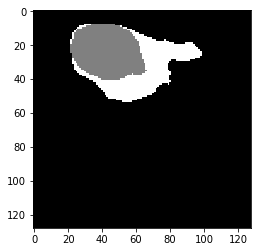

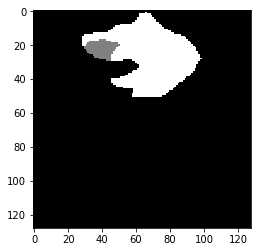

(1, 128, 128, 96)


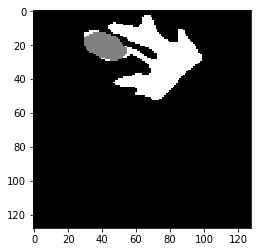

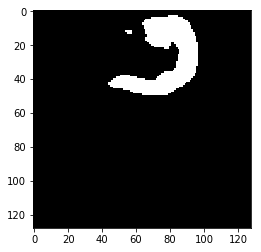

(1, 128, 128, 96)


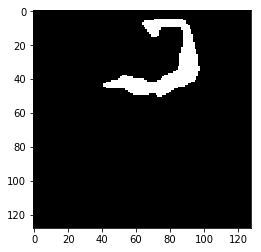

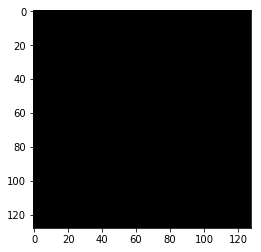

(1, 128, 128, 96)


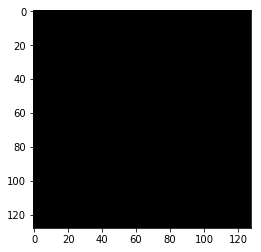

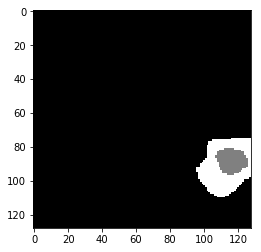

(1, 128, 128, 96)


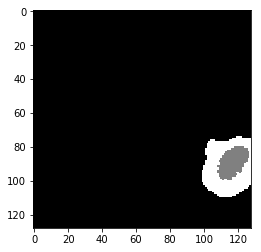

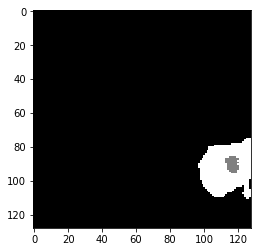

(1, 128, 128, 96)


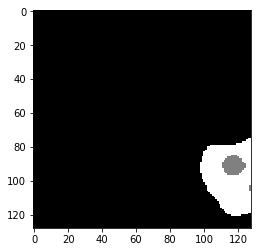

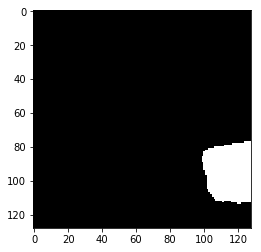

(1, 128, 128, 96)


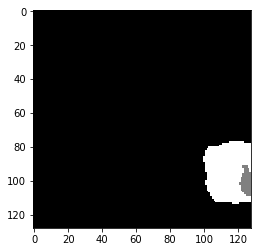

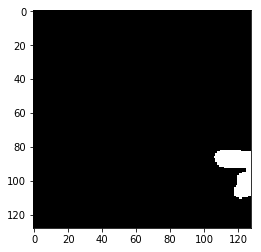

(1, 128, 128, 96)


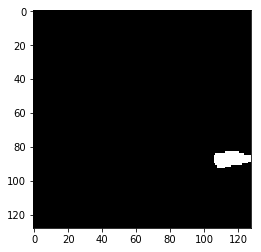

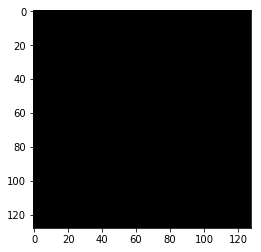

(1, 128, 128, 96)


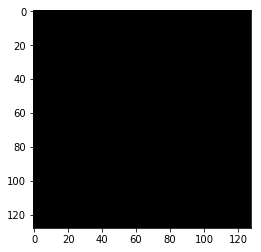

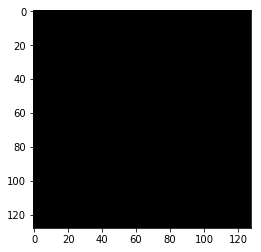

(1, 128, 128, 96)


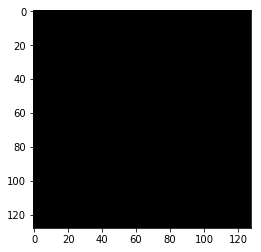

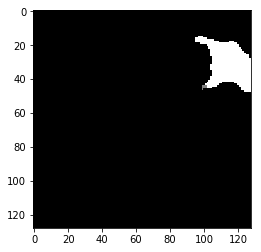

(1, 128, 128, 96)


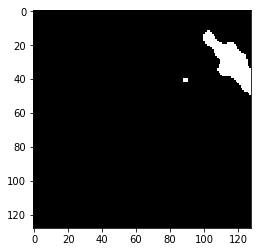

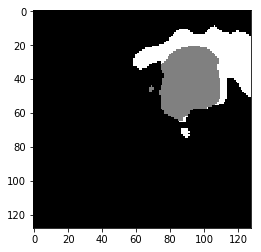

(1, 128, 128, 96)


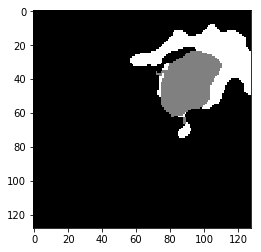

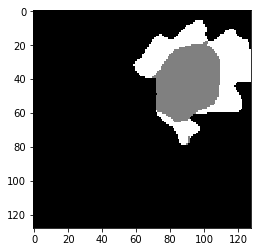

(1, 128, 128, 96)


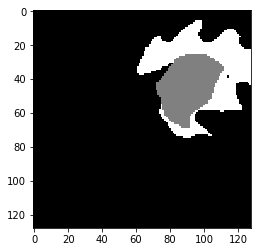

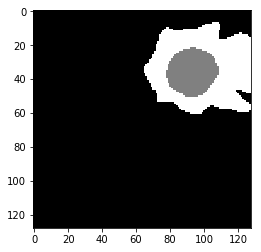

(1, 128, 128, 96)


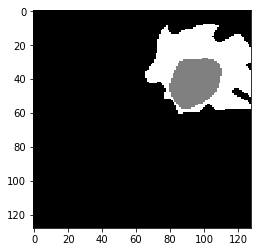

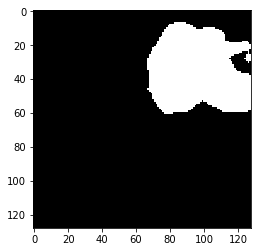

(1, 128, 128, 96)


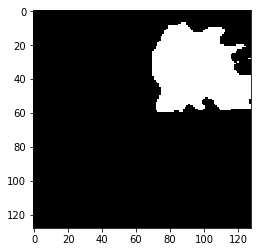

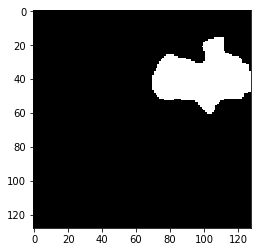

(1, 128, 128, 96)


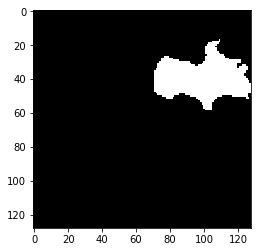

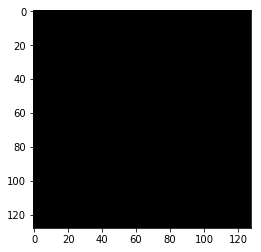

(1, 128, 128, 96)


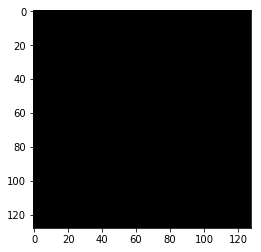

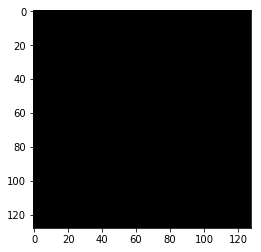

(1, 128, 128, 96)


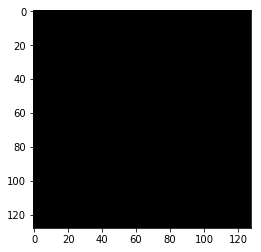

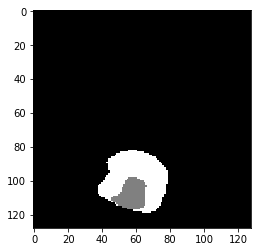

(1, 128, 128, 96)


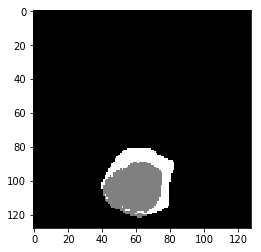

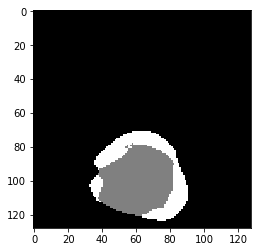

(1, 128, 128, 96)


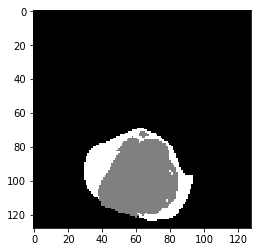

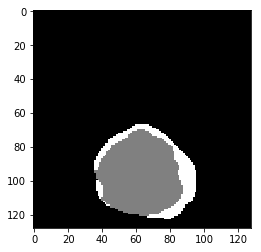

(1, 128, 128, 96)


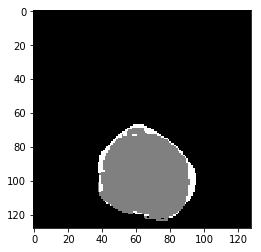

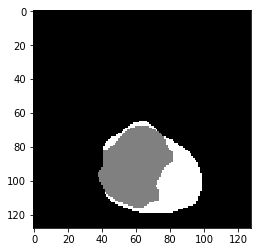

(1, 128, 128, 96)


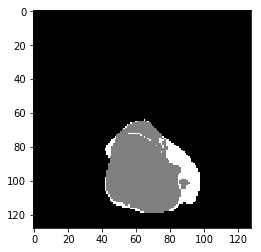

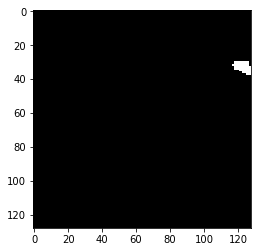

(1, 128, 128, 96)


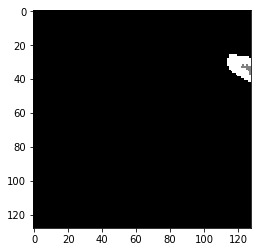

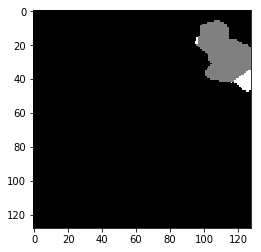

(1, 128, 128, 96)


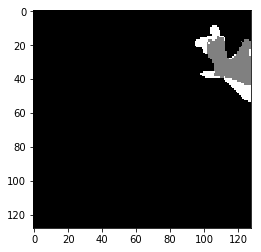

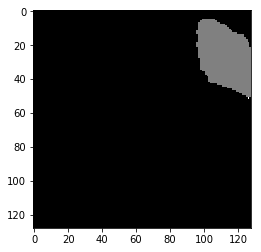

(1, 128, 128, 96)


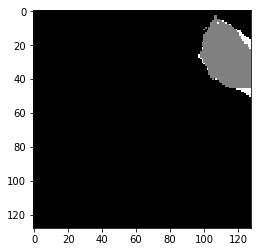

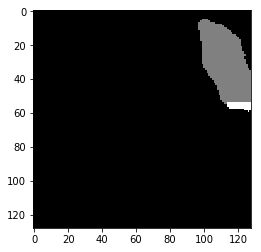

(1, 128, 128, 96)


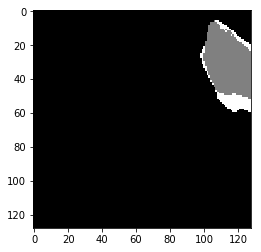

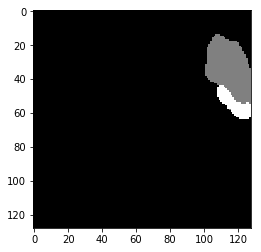

(1, 128, 128, 96)


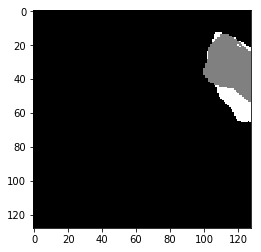

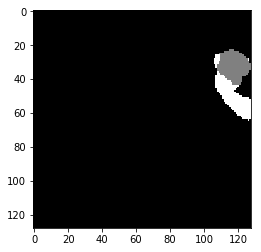

(1, 128, 128, 96)


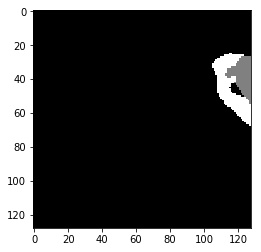

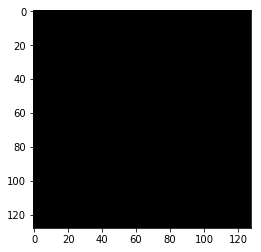

(1, 128, 128, 96)


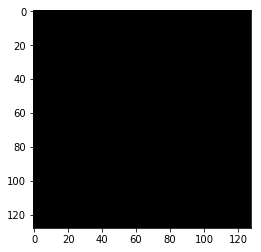

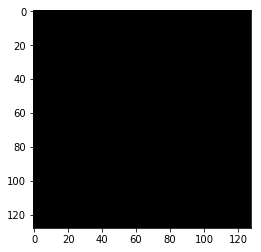

(1, 128, 128, 96)


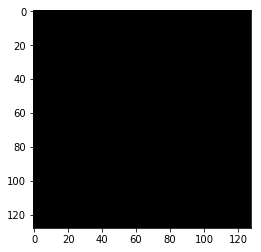

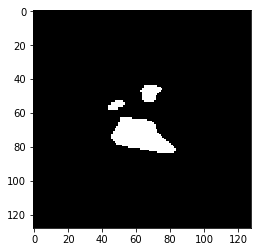

(1, 128, 128, 96)


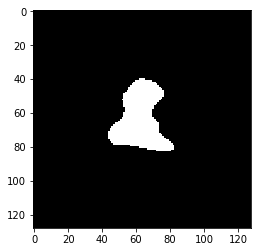

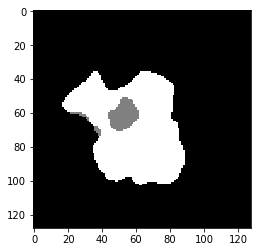

(1, 128, 128, 96)


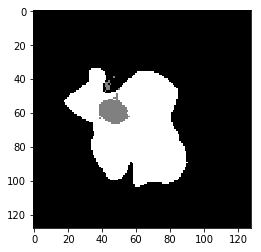

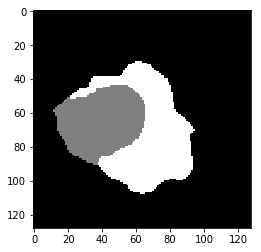

(1, 128, 128, 96)


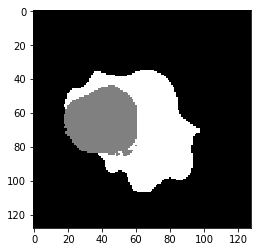

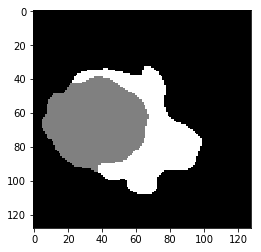

(1, 128, 128, 96)


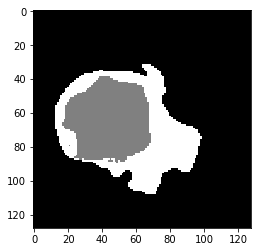

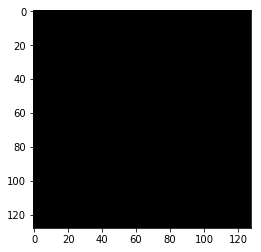

(1, 128, 128, 96)


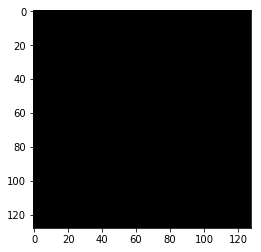

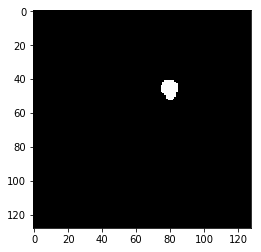

(1, 128, 128, 96)


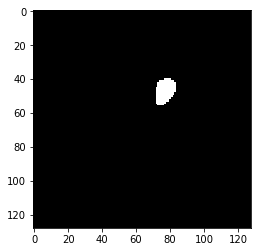

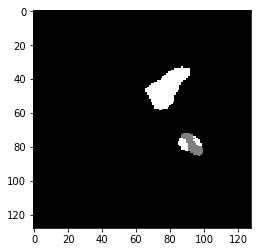

(1, 128, 128, 96)


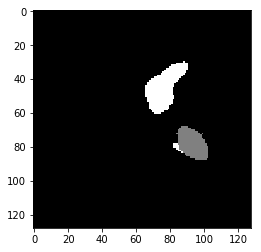

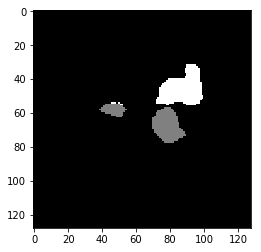

(1, 128, 128, 96)


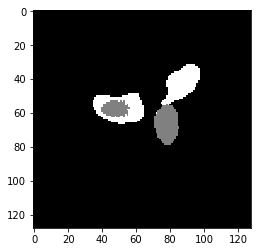

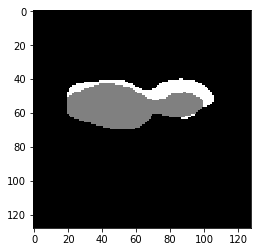

(1, 128, 128, 96)


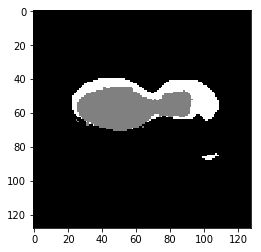

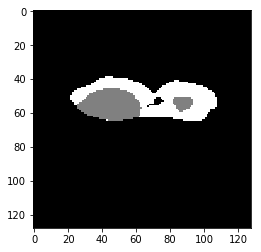

(1, 128, 128, 96)


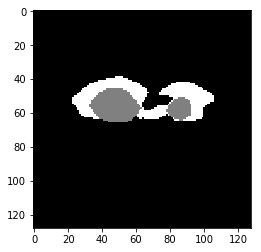

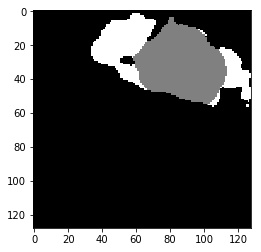

(1, 128, 128, 96)


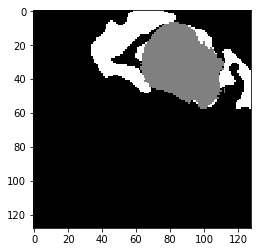

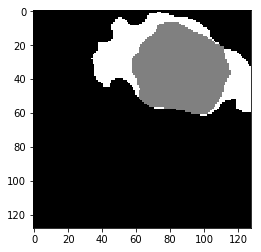

(1, 128, 128, 96)


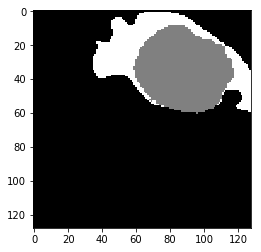

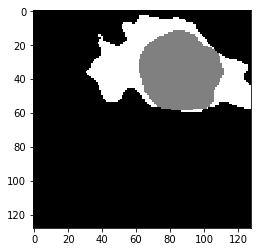

(1, 128, 128, 96)


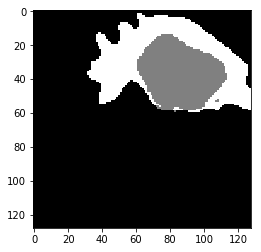

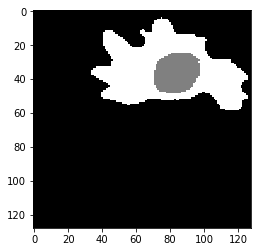

(1, 128, 128, 96)


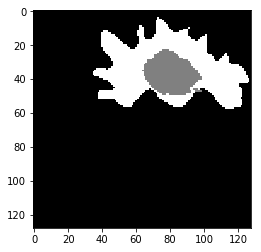

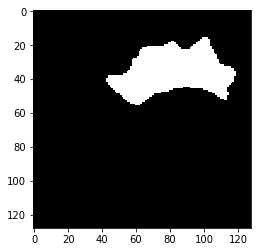

(1, 128, 128, 96)


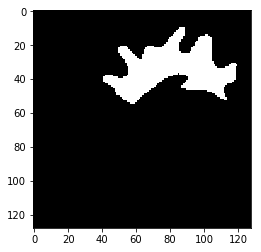

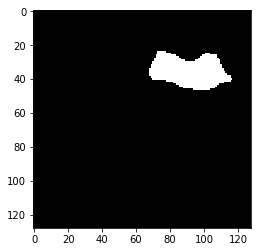

(1, 128, 128, 96)


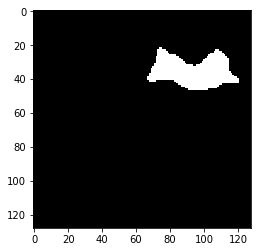

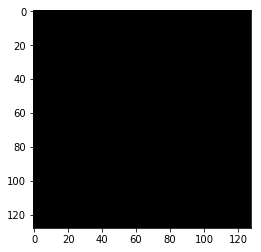

(1, 128, 128, 96)


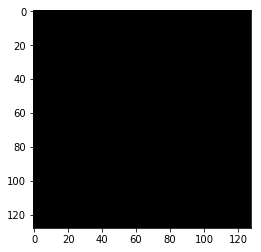

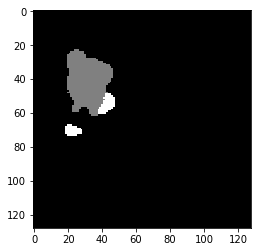

(1, 128, 128, 96)


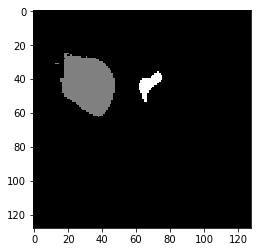

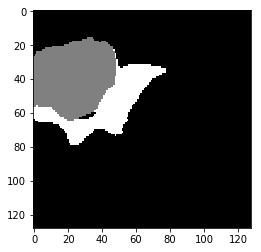

(1, 128, 128, 96)


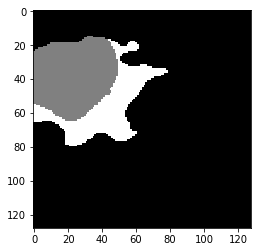

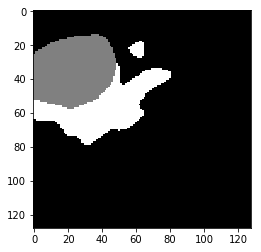

(1, 128, 128, 96)


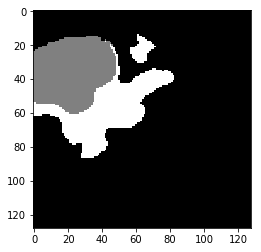

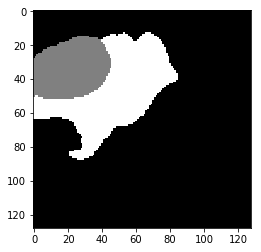

(1, 128, 128, 96)


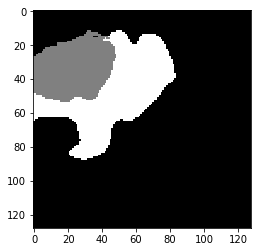

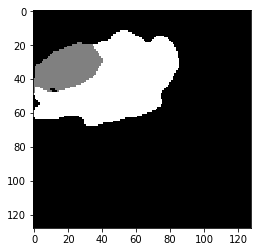

(1, 128, 128, 96)


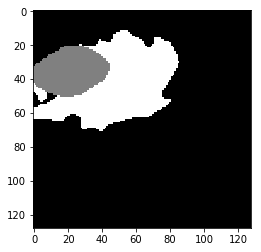

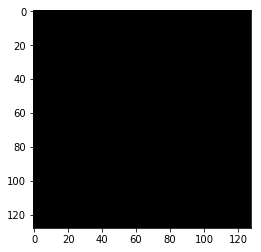

(1, 128, 128, 96)


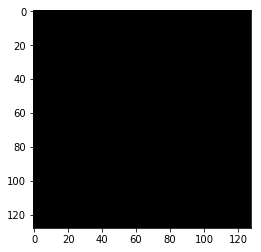

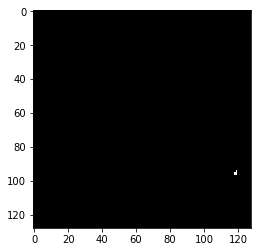

(1, 128, 128, 96)


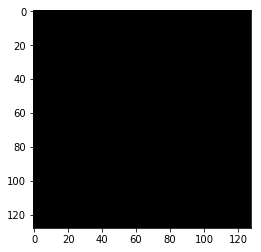

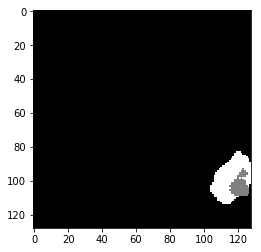

(1, 128, 128, 96)


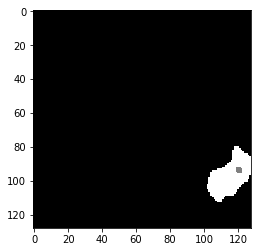

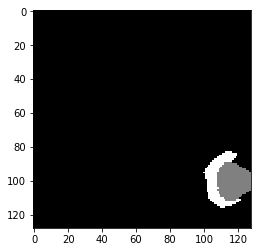

(1, 128, 128, 96)


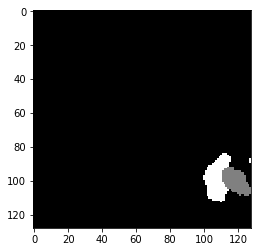

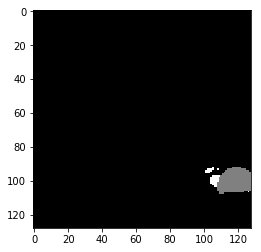

(1, 128, 128, 96)


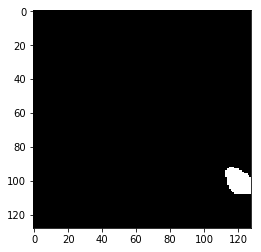

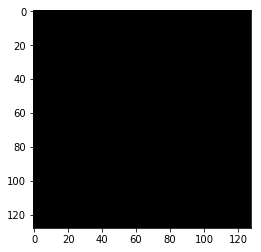

(1, 128, 128, 96)


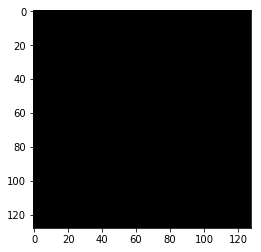

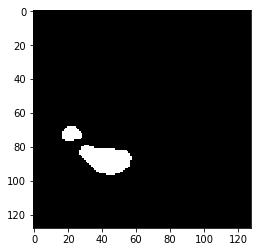

(1, 128, 128, 96)


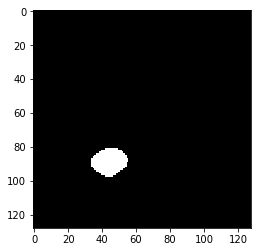

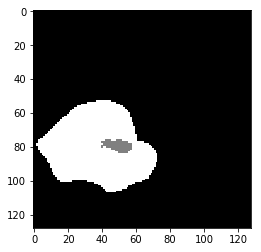

(1, 128, 128, 96)


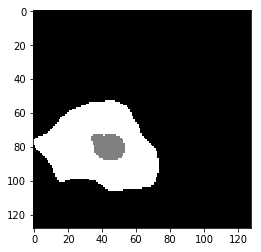

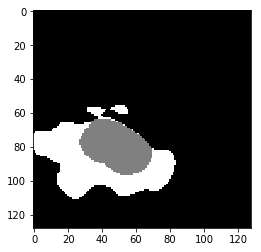

(1, 128, 128, 96)


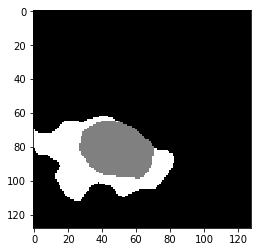

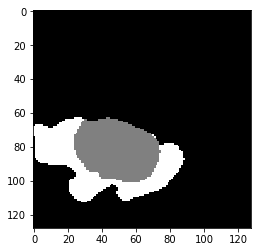

(1, 128, 128, 96)


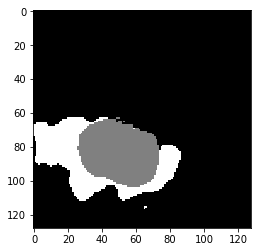

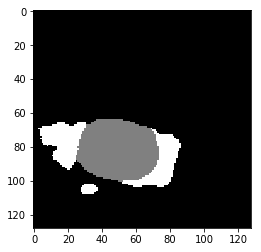

(1, 128, 128, 96)


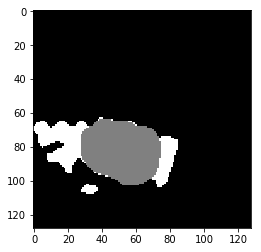

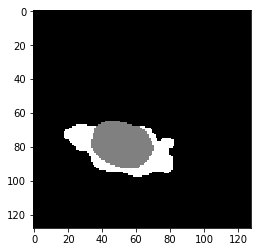

(1, 128, 128, 96)


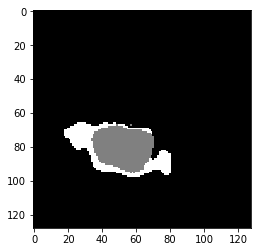

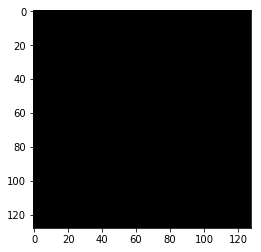

(1, 128, 128, 96)


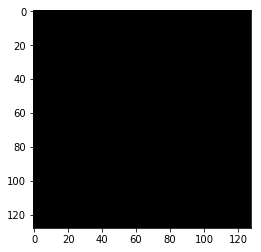

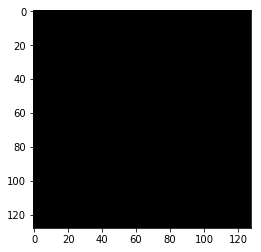

(1, 128, 128, 96)


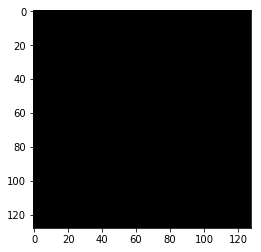

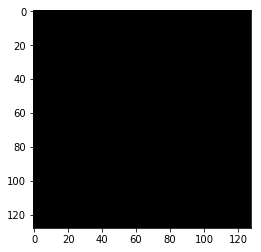

(1, 128, 128, 96)


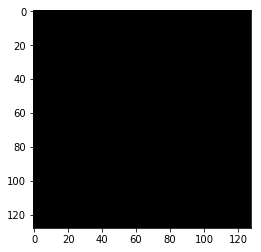

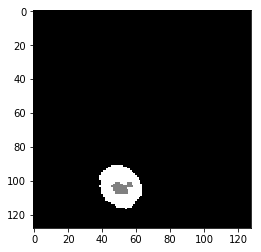

(1, 128, 128, 96)


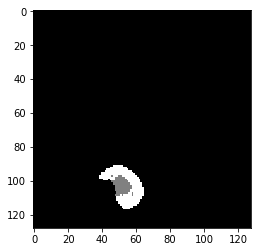

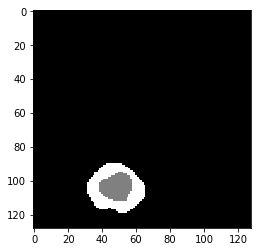

(1, 128, 128, 96)


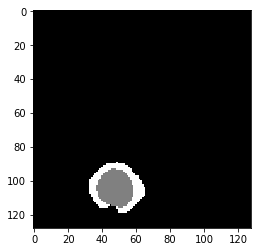

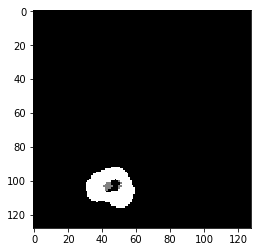

(1, 128, 128, 96)


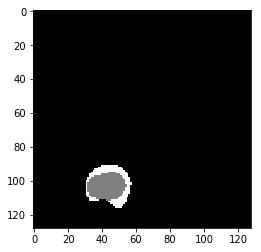

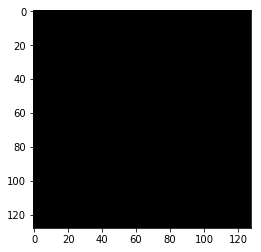

(1, 128, 128, 96)


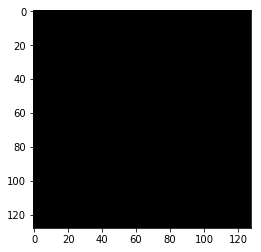

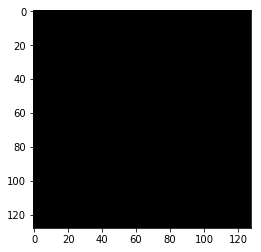

(1, 128, 128, 96)


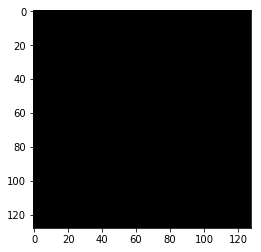

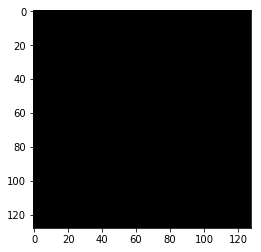

(1, 128, 128, 96)


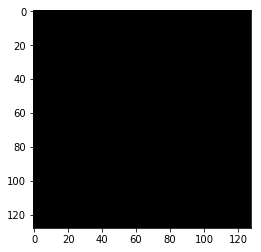

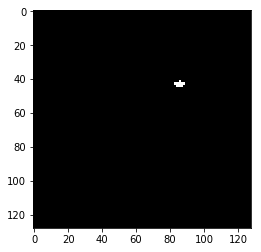

(1, 128, 128, 96)


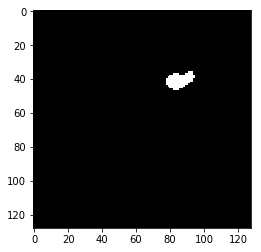

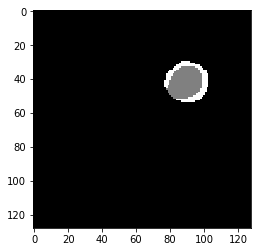

(1, 128, 128, 96)


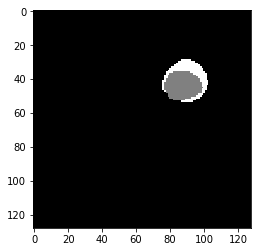

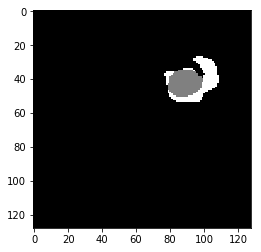

(1, 128, 128, 96)


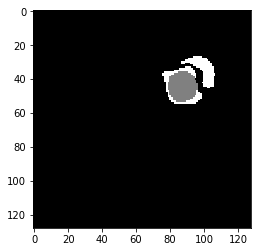

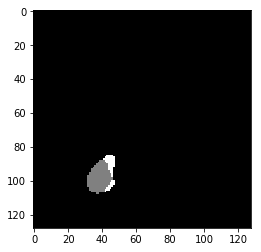

(1, 128, 128, 96)


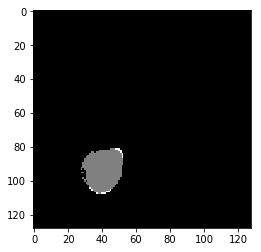

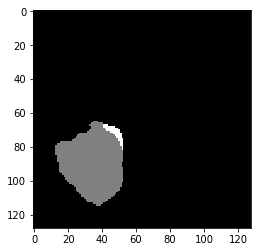

(1, 128, 128, 96)


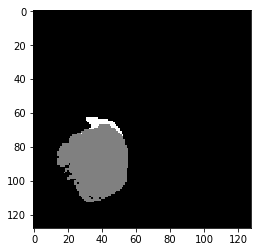

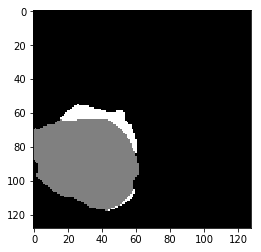

(1, 128, 128, 96)


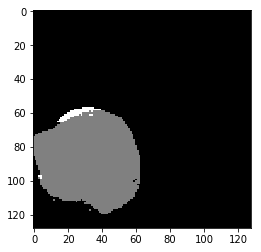

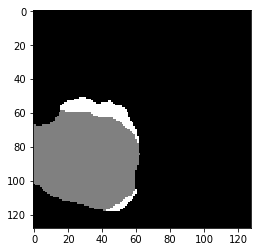

(1, 128, 128, 96)


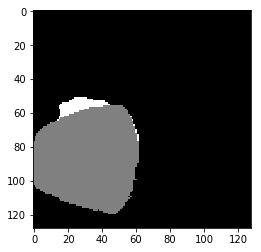

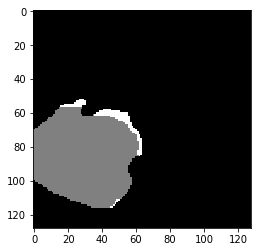

(1, 128, 128, 96)


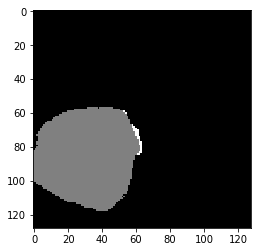

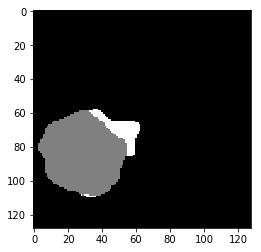

(1, 128, 128, 96)


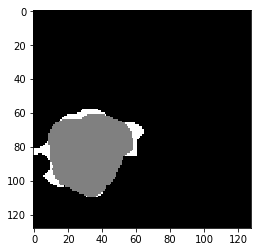

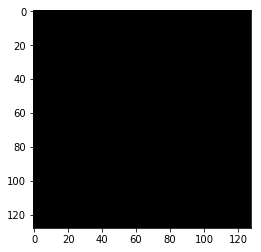

(1, 128, 128, 96)


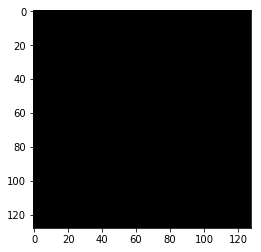

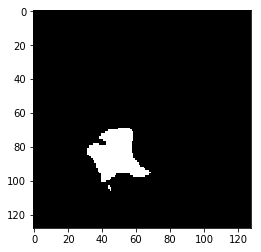

(1, 128, 128, 96)


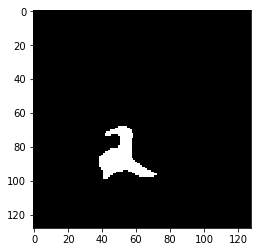

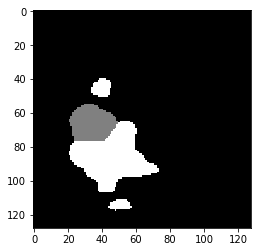

(1, 128, 128, 96)


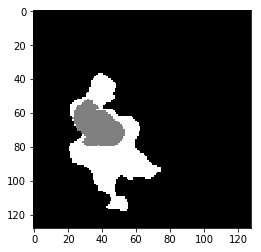

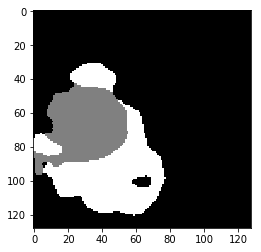

(1, 128, 128, 96)


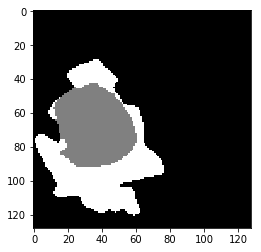

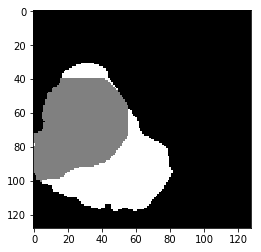

(1, 128, 128, 96)


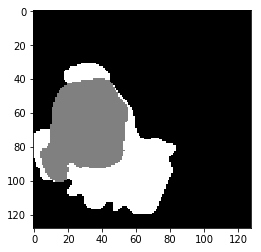

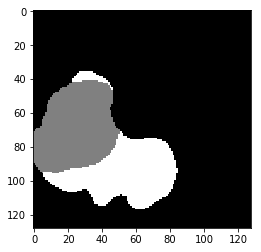

(1, 128, 128, 96)


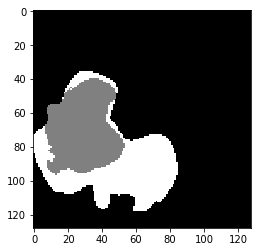

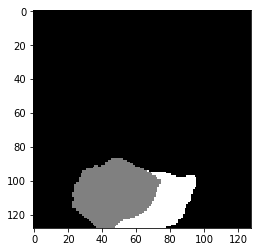

(1, 128, 128, 96)


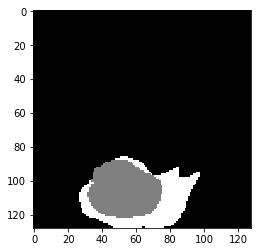

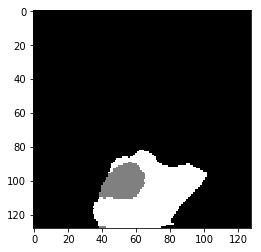

(1, 128, 128, 96)


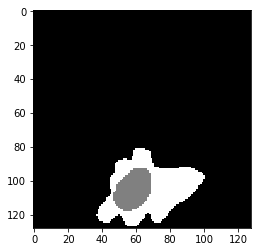

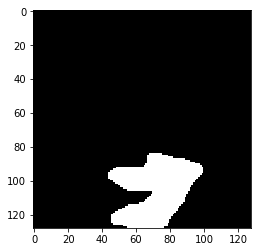

(1, 128, 128, 96)


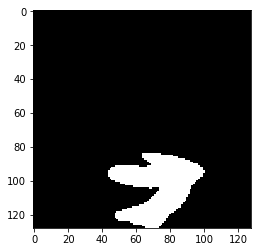

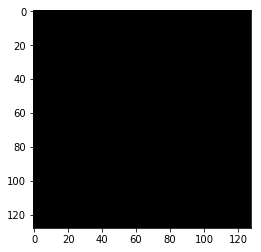

(1, 128, 128, 96)


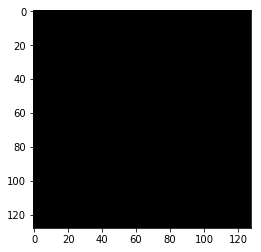

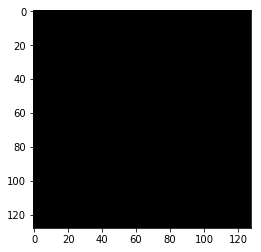

(1, 128, 128, 96)


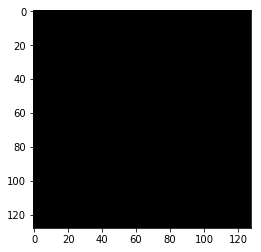

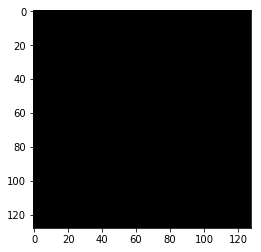

(1, 128, 128, 96)


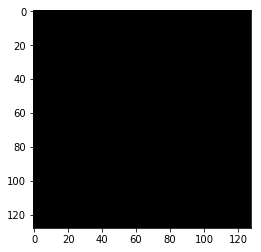

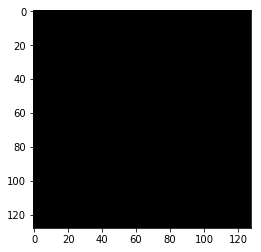

(1, 128, 128, 96)


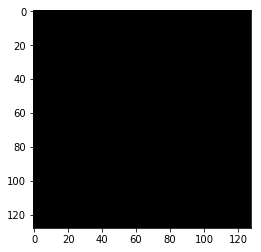

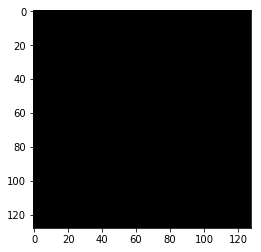

(1, 128, 128, 96)


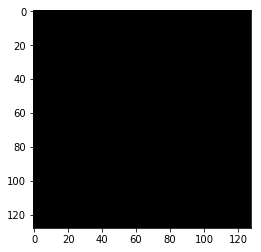

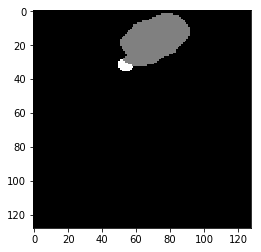

(1, 128, 128, 96)


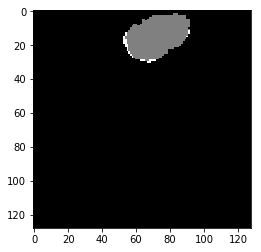

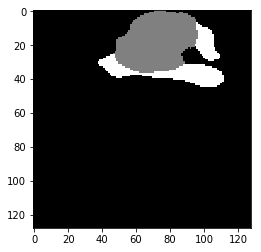

(1, 128, 128, 96)


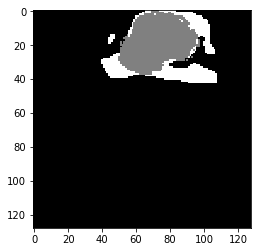

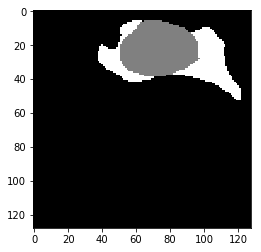

(1, 128, 128, 96)


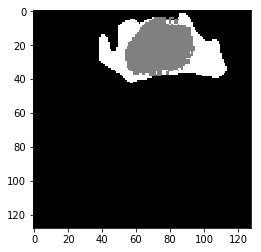

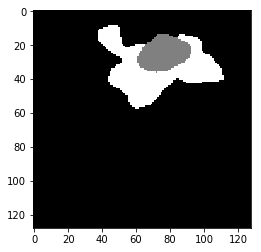

(1, 128, 128, 96)


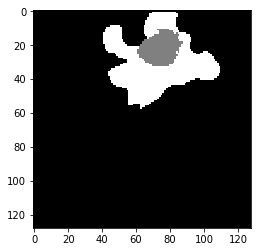

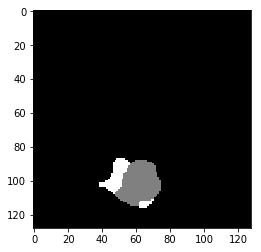

(1, 128, 128, 96)


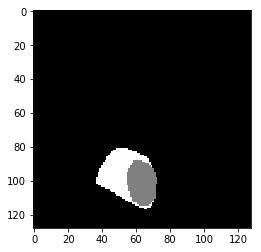

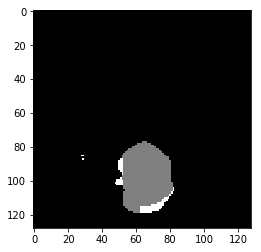

(1, 128, 128, 96)


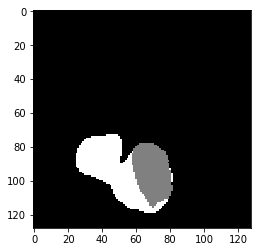

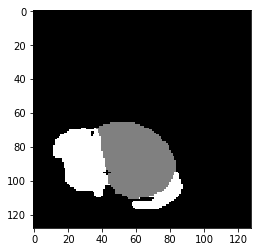

(1, 128, 128, 96)


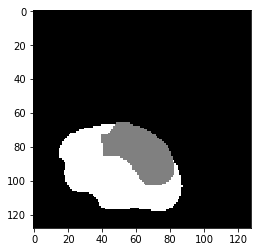

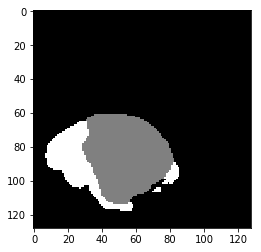

(1, 128, 128, 96)


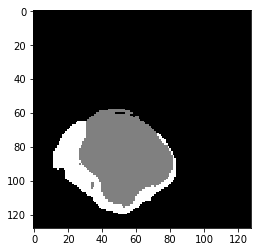

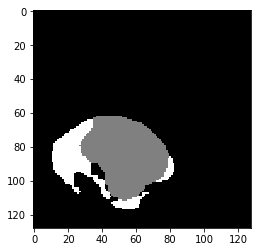

(1, 128, 128, 96)


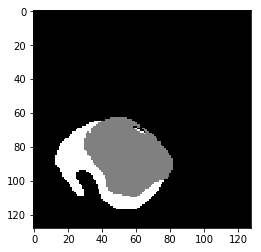

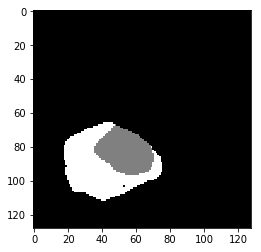

(1, 128, 128, 96)


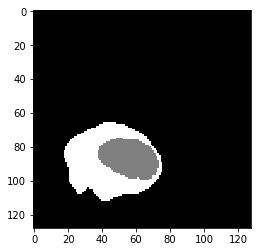

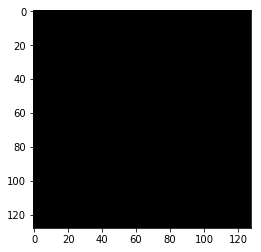

(1, 128, 128, 96)


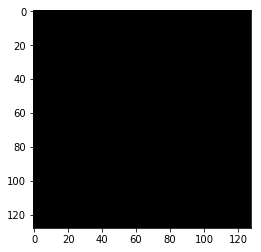

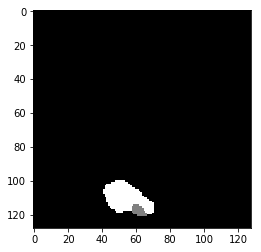

(1, 128, 128, 96)


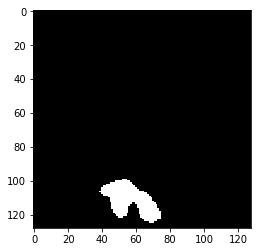

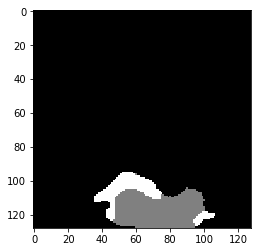

(1, 128, 128, 96)


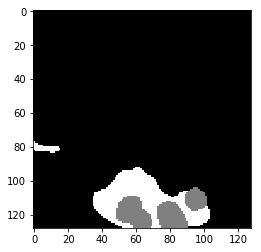

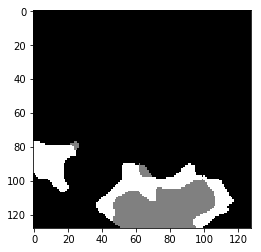

(1, 128, 128, 96)


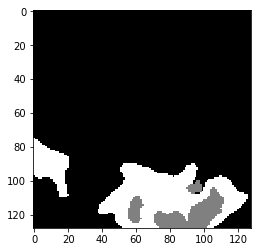

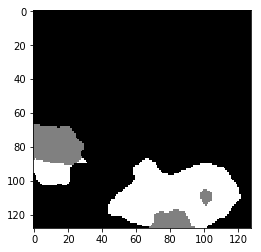

(1, 128, 128, 96)


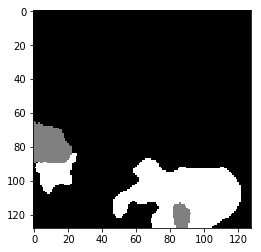

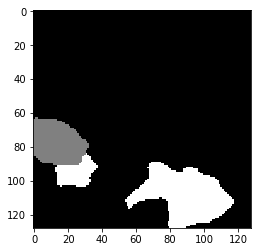

(1, 128, 128, 96)


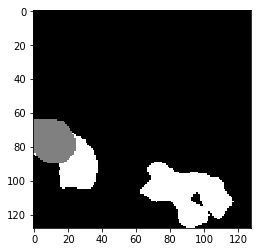

In [5]:
def comparison_val_all(j):
    case = SAMPLE[j]
    key0 = case[:2]
    key1 = case[3:]
    _, X, Y, Z = f[key0][key1].shape
    val_batch = [];
    val_label = [];
    x = X//2
    y = Y//2
    z = Z//2
    val_batch.append(f[key0][key1][0:2,x-64:x+64,y-64:y+64,z-48:z+48])
    
    #deal with 2cp, reduce 5 label to 3 label
    temporary_label=f[key0][key1][4,x-64:x+64,y-64:y+64,z-48:z+48]
    temporary_label[temporary_label==3]=1
    temporary_label[temporary_label==4]=1
    val_label.append(temporary_label)
    val_batch = np.array(val_batch)
    val_label = np.array(val_label)
    val_batch = torch.from_numpy(val_batch)
    val_label = torch.from_numpy(val_label)
    val_y = torch.Tensor.long(val_label)
    val_x = Variable(val_batch).cuda(2)
    y_pred = net.forward(val_x)
    y_pred = y_pred.view(3,-1)
    _, y_pred = torch.max(y_pred, 0)
    y_pred = y_pred.view(128,128,96)
    array_image = y_pred.data.cpu().numpy()
    for k in range(30, 90, 10):
        plt.imshow(array_image[:,:,k], cmap = 'gray')
        plt.show()
        val_yn = val_y.numpy()
        print(val_yn.shape)
        plt.imshow(val_yn[0,:,:,k], cmap = 'gray')
        plt.show()
    return 1

def validation_all():
    for j in range(len(SAMPLE)):
        comparison_val_all(j)
        
#Check the training result
netpure=Unetpure()
netpure.load_state_dict(torch.load("/home/yiqin/TumorSeg/unified_system/unet_module/u_net_pure_2cp032410520624.txt"))
net=Unetseg(netpure)
net.load_state_dict(torch.load("/home/yiqin/TumorSeg/unified_system/unet_module/u_net_2cp032410520624.txt"))
net.cuda(2)
import matplotlib.pyplot as plt
validation_all()

#training result not good. Abandon this approach